In [1]:
import pandas as pd
import spacy
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [2]:
!python -m spacy download fr_core_news_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 64.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
data_dir = "/content/"
train_path = os.path.join(data_dir, "train (1).csv")
test_path = os.path.join(data_dir, "test (1).csv")

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [20]:
 #Exploration rapide
print(train_df.info())
print(train_df["type"].value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12473 entries, 0 to 12472
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   doc_id        12473 non-null  object
 1   titre         12473 non-null  object
 2   type          12473 non-null  object
 3   difficulte    12473 non-null  object
 4   cout          12473 non-null  object
 5   ingredients   12473 non-null  object
 6   recette       12473 non-null  object
 7   text          12473 non-null  object
 8   cleaned_text  12473 non-null  object
dtypes: object(9)
memory usage: 877.1+ KB
None
type
Plat principal    0.465165
Dessert           0.301611
Entrée            0.233224
Name: proportion, dtype: float64


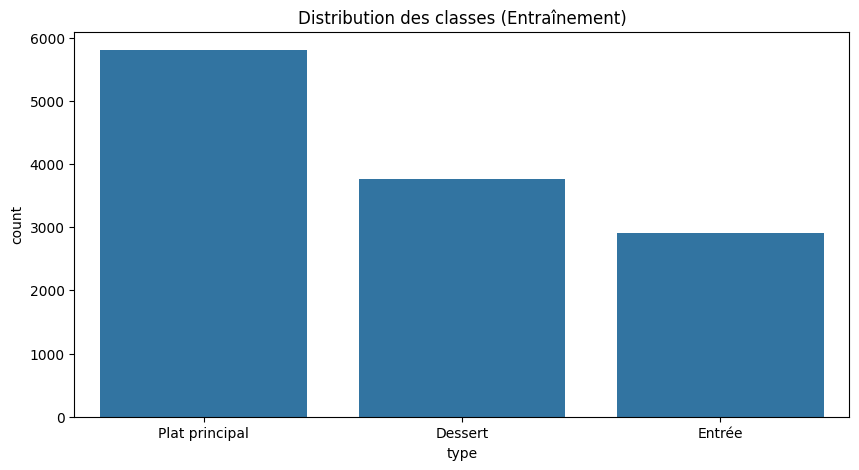

In [21]:
plt.figure(figsize=(10, 5))
sns.countplot(x='type', data=train_df, order=train_df['type'].value_counts().index)
plt.title('Distribution des classes (Entraînement)')
plt.show()

In [22]:
from sklearn.metrics import precision_recall_fscore_support

major_class = train_df["type"].mode()[0]
baseline_preds = [major_class] * len(test_df)

# Évaluation
precision, recall, f1, _ = precision_recall_fscore_support(
    test_df["type"],
    baseline_preds,
    average='micro'
)
print("La précision de la baseline classe majoritaire : ",precision)

La précision de la baseline classe majoritaire :  0.46397694524495675


F1-score (weighted) de la baseline majoritaire: 0.2941

                precision    recall  f1-score   support

       Dessert       0.00      0.00      0.00       407
        Entrée       0.00      0.00      0.00       337
Plat principal       0.46      1.00      0.63       644

      accuracy                           0.46      1388
     macro avg       0.15      0.33      0.21      1388
  weighted avg       0.22      0.46      0.29      1388



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


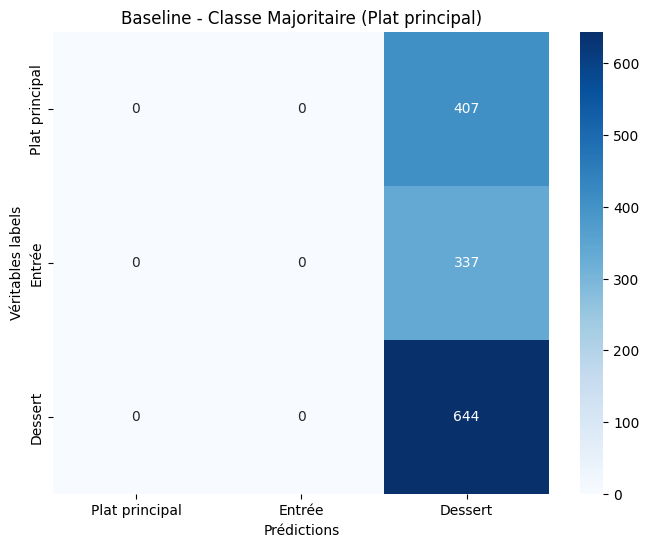

In [34]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Trouver la classe majoritaire dans le train
majority_class = train_df['type'].value_counts().idxmax()

# Créer des prédictions majoritaires
baseline_preds = [majority_class] * len(test_df)

# Calcul des métriques
cm = confusion_matrix(test_df['type'], baseline_preds)
f1 = f1_score(test_df['type'], baseline_preds, average='weighted')

print(f"F1-score (weighted) de la baseline majoritaire: {f1:.4f}\n")

# Affichage détaillé
print(classification_report(test_df['type'], baseline_preds))

# Visualisation matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',
           xticklabels=train_df['type'].unique(),
           yticklabels=train_df['type'].unique(),
           cmap='Blues')
plt.title(f"Baseline - Classe Majoritaire ({majority_class})")
plt.xlabel('Prédictions')
plt.ylabel('Véritables labels')
plt.show()

In [25]:
print("Répartition des classes dans train_df :")
print(train_df['type'].value_counts())

print("\nRépartition des classes dans test_df :")
print(test_df['type'].value_counts())

Répartition des classes dans train_df :
type
Plat principal    5802
Dessert           3762
Entrée            2909
Name: count, dtype: int64

Répartition des classes dans test_df :
type
Plat principal    644
Dessert           407
Entrée            337
Name: count, dtype: int64


In [27]:
# Charger le modèle français de spaCy
nlp = spacy.load("fr_core_news_sm")
stop_words = list(nlp.Defaults.stop_words)  # Convertir le set en liste

def clean_text(text):
    doc = nlp(text.lower())  # Garde les apostrophes
    tokens = [
        token.lemma_.strip()
        for token in doc
        if token.is_alpha  # Supprime uniquement la ponctuation et chiffres
        and len(token.text) > 1  # Garde les mots courts utiles
    ]
    return " ".join(tokens)


train_df['text'] = train_df['titre'] + " " + train_df['recette']
test_df['text'] = test_df['titre'] + " " + test_df['recette']

# Application du nettoyage
train_df['cleaned_text'] = train_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

# Vectorisation TF-IDF avec paramètres adaptés au français
vectorizer = TfidfVectorizer(
    max_features=15000,  # Augmenter le nombre de mots
    ngram_range=(1, 3),  # Ajouter trigrammes
    min_df=2,  # Supprime les mots rares (apparus une seule fois)
    max_df=0.9,  # Supprime les mots trop fréquents (bruit)
    stop_words=None  # Ne pas supprimer de stop words automatiquement
)

# Création des jeux de données
X_train = vectorizer.fit_transform(train_df['text'])
X_test = vectorizer.transform(test_df['text'])

X_train_clean = vectorizer.fit_transform(train_df['cleaned_text'])
X_test_clean = vectorizer.transform(test_df['cleaned_text'])


In [28]:
encoder = LabelEncoder()

# Apprendre toutes les classes à partir des données combinées
encoder.fit(pd.concat([train_df['type'], test_df['type']], axis=0).unique())

# Transformer les labels
y_train = encoder.transform(train_df['type'])
y_test = encoder.transform(test_df['type'])


In [29]:
# Entraînement des modèles
model_clean = SVC(
    kernel='linear',
    C=1.0,  # Hyperparamètre de régularisation
    class_weight='balanced',
    probability=True
)

model_clean.fit(X_train_clean, y_train)
y_pred_clean = model_clean.predict(X_test_clean)

In [32]:
import joblib

joblib.dump(model_clean, "svm_model_tfidf.pkl")
print(" Modèle SVM sauvegardé sous 'svm_model_tfidf.pkl'")


 Modèle SVM sauvegardé sous 'svm_model_tfidf.pkl'



Évaluation TF-IDF+SVM
Accuracy: 0.8746397694524496
                precision    recall  f1-score   support

       Dessert       0.98      1.00      0.99       407
        Entrée       0.72      0.82      0.76       337
Plat principal       0.90      0.83      0.86       644

      accuracy                           0.87      1388
     macro avg       0.87      0.88      0.87      1388
  weighted avg       0.88      0.87      0.88      1388



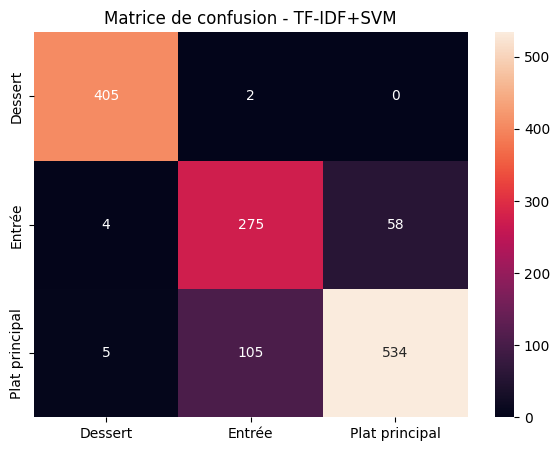

In [33]:
# Évaluation comparative
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n\033[1mÉvaluation {model_name}\033[0m")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred, target_names=encoder.classes_))

    # Matrice de confusion
    plt.figure(figsize=(7,5))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=encoder.classes_,
                yticklabels=encoder.classes_)
    plt.title(f"Matrice de confusion - {model_name}")
    plt.show()

evaluate_model(y_test, y_pred_clean, "TF-IDF+SVM")